In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#

In [2]:
df=pd.read_csv('unified_ecommerce_data.csv')

In [3]:
df

,Channel,Campaign_Type,Impressions,Clicks,Cost,Conversions,Revenue,Profit,Conversion_Rate,ROI
0,Google,Cross-network,37580588.0,441745.0,343674.0,23165.9,3166297.3,2822623.3,6.740661,8.213084
1,Google,Display Network,353827.0,11865.0,2951.7,108.1,18460.4,15508.7,3.662296,5.254159
2,Google,Search Network,1385843.0,149630.0,149558.8,12464.0,2330129.0,2180570.2,8.333846,14.580019
3,Microsoft,Search & content,136673.0,20193.0,26229.9,2790.0,505865.1,479635.2,10.636716,1828.581886
4,Microsoft,Shopping,3574331.0,45489.0,24572.2,1740.0,216138.7,191566.5,7.081173,779.606629
5,Meta,Unknown,3498822.0,72228.0,21829.9,2840.0,527936.6,506106.7,861.646175,463913.954644


In [4]:
# prompt: in coversion rate there is one value is 861.646175 please convert it into 8.61646175 also in ROI  463913.954644 convert it into 4639.13954644

df['Conversion_Rate'] = df['Conversion_Rate'].replace(861.646175, 8.61646175)
df['ROI'] = df['ROI'].replace(463913.954644, 4639.13954644)
df['ROI'] = df['ROI'].replace(1828.581886, 18.28581886)
df['ROI'] = df['ROI'].replace(779.606629, 7.79606629)


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import norm



# Calculate CPC and CVR
df['CPC'] = df['Cost'] / df['Clicks']
df['CVR'] = df['Conversions'] / df['Clicks']

def monte_carlo_allocation(data, total_budget, num_simulations=10000):
    num_channels = len(data)
    best_allocation = None
    best_conversions = 0

    for _ in range(num_simulations):
        # Generate random allocation
        allocation = np.random.dirichlet(np.ones(num_channels)) * total_budget

        # Ensure minimum 10% allocation per channel
        while np.any(allocation < 0.1 * total_budget):
            allocation = np.random.dirichlet(np.ones(num_channels)) * total_budget

        # Simulate conversions with some randomness
        simulated_clicks = allocation / data['CPC'].values
        simulated_conversions = simulated_clicks * np.random.normal(data['CVR'].values, data['CVR'].values * 0.1)
        total_conversions = np.sum(simulated_conversions)

        if total_conversions > best_conversions:
            best_conversions = total_conversions
            best_allocation = allocation

    return best_allocation, best_conversions

# Run Monte Carlo simulation
total_budget = 200000
best_allocation, best_conversions = monte_carlo_allocation(df, total_budget)

# Update the dataframe with results
df['Allocated_Budget'] = best_allocation
df['Estimated_Clicks'] = df['Allocated_Budget'] / df['CPC']
df['Estimated_Conversions'] = df['Estimated_Clicks'] * df['CVR']

# Print results
print("Optimized Budget Allocation:")
print(df[['Channel', 'Campaign_Type', 'Allocated_Budget', 'Estimated_Conversions']])
print(f"\nTotal Budget Allocated: ${df['Allocated_Budget'].sum():.2f}")
print(f"Total Estimated Conversions: {df['Estimated_Conversions'].sum():.2f}")



Optimized Budget Allocation:
     Channel     Campaign_Type  Allocated_Budget  Estimated_Conversions
0     Google     Cross-network      22147.017179            1492.855396
1     Google   Display Network      27630.222421            1011.900614
2     Google    Search Network      24911.575332            2076.092312
3  Microsoft  Search & content      30465.985902            3240.580432
4  Microsoft          Shopping      20357.787495            1441.570158
5       Meta           Unknown      74487.411672            9690.573440

Total Budget Allocated: $200000.00
Total Estimated Conversions: 18953.57


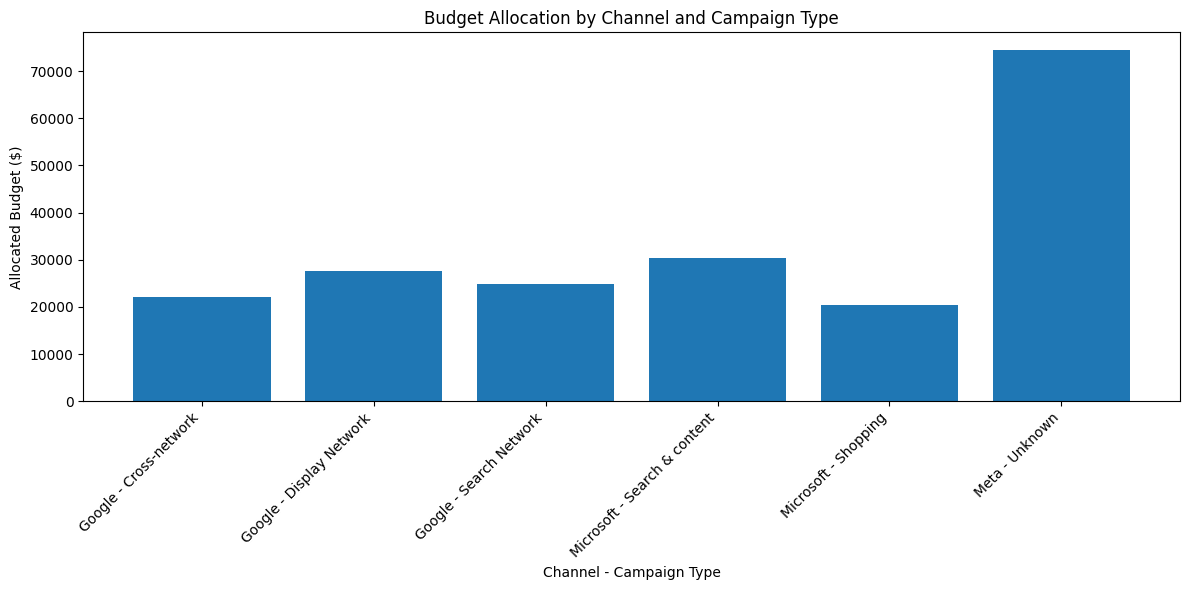

In [6]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(df['Channel'] + ' - ' + df['Campaign_Type'], df['Allocated_Budget'])
plt.title('Budget Allocation by Channel and Campaign Type')
plt.xlabel('Channel - Campaign Type')
plt.ylabel('Allocated Budget ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize

# Load and preprocess the data
data = pd.DataFrame({
    'Channel': ['Google', 'Google', 'Google', 'Microsoft', 'Microsoft', 'Meta'],
    'Campaign_Type': ['Cross-network', 'Display Network', 'Search Network', 'Search & content', 'Shopping', 'Unknown'],
    'Impressions': [37580588.0, 353827.0, 1385843.0, 136673.0, 3574331.0, 3498822.0],
    'Clicks': [441745.0, 11865.0, 149630.0, 20193.0, 45489.0, 72228.0],
    'Cost': [343674.0, 2951.7, 149558.8, 26229.9, 24572.2, 21829.9],
    'Conversions': [23165.9, 108.1, 12464.0, 2790.0, 1740.0, 2840.0],
    'Revenue': [3166297.3, 18460.4, 2330129.0, 505865.1, 216138.7, 527936.6],
    'Profit': [2822623.3, 15508.7, 2180570.2, 479635.2, 191566.5, 506106.7],
    'Conversion_Rate': [6.7406618, 3.6622965, 8.33384614, 10.6367161, 7.081173779, 8.61646175],
    'ROI': [8.213084, 5.254159, 14.580019, 18.28581886, 7.79606629, 463.913954644]
})

# Calculate CPC and CVR
data['CPC'] = data['Cost'] / data['Clicks']
data['CVR'] = data['Conversions'] / data['Clicks']

# Bayesian Optimization functions
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)

    with np.errstate(divide='warn'):
        imp = mu - np.max(Y_sample) - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(1, -1), X_sample, Y_sample, gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun # Remove [0] to treat res.fun as a float
            min_x = res.x

    return min_x.reshape(1, -1)

def objective_function(x):
    # Simulate conversions based on budget allocation
    allocated_budget = x * 200000  # Scale to total budget
    estimated_clicks = allocated_budget / data['CPC'].values
    estimated_conversions = estimated_clicks * data['CVR'].values
    return np.sum(estimated_conversions)

# Bayesian Optimization
n_channels = len(data)
bounds = np.array([[0.1, 0.9]] * n_channels)  # Each channel gets between 10% and 90% of budget
n_iterations = 100

X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(10, n_channels))
X_sample = X_sample / np.sum(X_sample, axis=1)[:, np.newaxis]  # Normalize to sum to 1
Y_sample = np.array([objective_function(x) for x in X_sample])

kernel = Matern(nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

for i in range(n_iterations):
    gpr.fit(X_sample, Y_sample)

    next_sample = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    next_sample = next_sample / np.sum(next_sample)  # Normalize to sum to 1

    if np.any(next_sample < 0.1):
        continue  # Skip this iteration if any channel gets less than 10%

    next_objective = objective_function(next_sample[0])

    X_sample = np.vstack((X_sample, next_sample))
    Y_sample = np.append(Y_sample, next_objective)

# Get the best allocation
best_idx = np.argmax(Y_sample)
best_allocation = X_sample[best_idx]

# Update the dataframe with results
data['Allocated_Budget'] = best_allocation * 200000
data['Estimated_Clicks'] = data['Allocated_Budget'] / data['CPC']
data['Estimated_Conversions'] = data['Estimated_Clicks'] * data['CVR']

# Print results
print("Optimized Budget Allocation:")
print(data[['Channel', 'Campaign_Type', 'Allocated_Budget', 'Estimated_Conversions']])
print(f"\nTotal Budget Allocated: ${data['Allocated_Budget'].sum():.2f}")
print(f"Total Estimated Conversions: {data['Estimated_Conversions'].sum():.2f}")



Optimized Budget Allocation:
     Channel     Campaign_Type  Allocated_Budget  Estimated_Conversions
0     Google     Cross-network      21892.208802            1475.679626
1     Google   Display Network      10966.993390             401.643794
2     Google    Search Network      34251.579512            2854.473873
3  Microsoft  Search & content      22152.661746            2356.315742
4  Microsoft          Shopping      53119.300853            3761.469607
5       Meta           Unknown      57617.255698            7495.820237

Total Budget Allocated: $200000.00
Total Estimated Conversions: 18345.40


Optimized Budget Allocation:
     Channel     Campaign_Type  Allocated_Budget  Estimated_Conversions
0     Google     Cross-network      21688.678444            1461.960358
1     Google   Display Network      21739.299009             796.157543
2     Google    Search Network      22436.080184            1869.788411
3  Microsoft  Search & content      22401.040210            2382.735031
4  Microsoft          Shopping      20579.474027            1457.268114
5       Meta           Unknown      89011.403078           11580.097885

Total Budget Allocated: $197855.97
Total Estimated Conversions: 19548.01


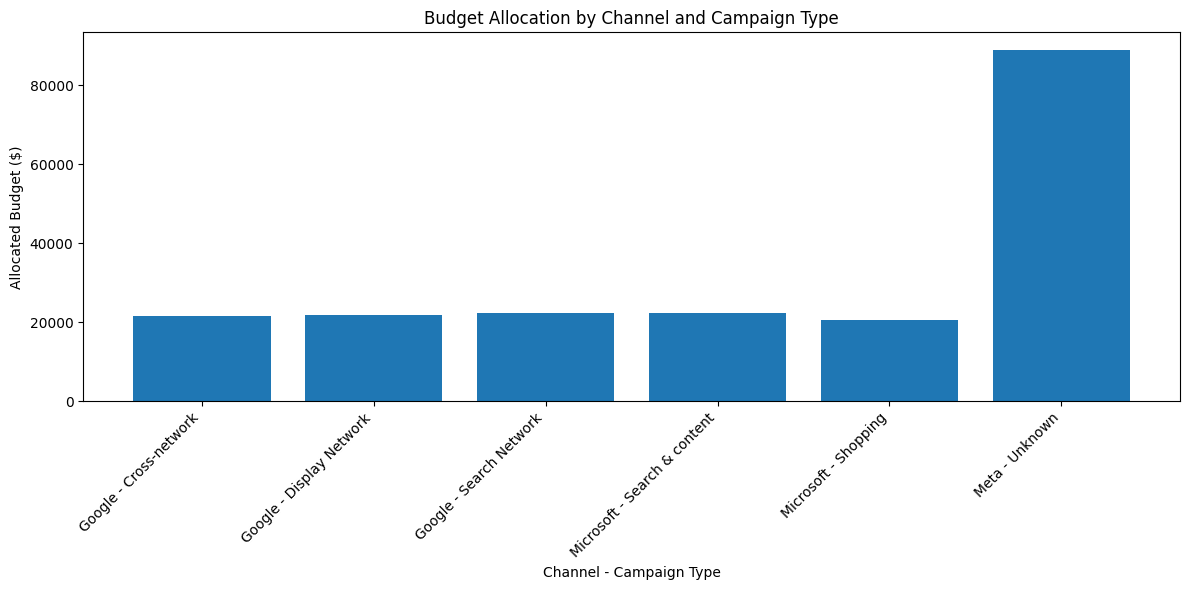

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.optimize import minimize
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from typing import Tuple

data = pd.DataFrame({
    'Channel': ['Google', 'Google', 'Google', 'Microsoft', 'Microsoft', 'Meta'],
    'Campaign_Type': ['Cross-network', 'Display Network', 'Search Network', 'Search & content', 'Shopping', 'Unknown'],
    'Impressions': [37580588.0, 353827.0, 1385843.0, 136673.0, 3574331.0, 3498822.0],
    'Clicks': [441745.0, 11865.0, 149630.0, 20193.0, 45489.0, 72228.0],
    'Cost': [343674.0, 2951.7, 149558.8, 26229.9, 24572.2, 21829.9],
    'Conversions': [23165.9, 108.1, 12464.0, 2790.0, 1740.0, 2840.0],
    'Revenue': [3166297.3, 18460.4, 2330129.0, 505865.1, 216138.7, 527936.6],
    'Profit': [2822623.3, 15508.7, 2180570.2, 479635.2, 191566.5, 506106.7],
    'Conversion_Rate': [6.7406618, 3.6622965, 8.33384614, 10.6367161, 7.081173779, 8.61646175],
    'ROI': [8.213084, 5.254159, 14.580019, 18.28581886, 7.79606629, 463.913954644]
})

numeric_columns = ['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue', 'Profit', 'Conversion_Rate', 'ROI']
data[numeric_columns] = data[numeric_columns].astype(np.float32)

data['CPC'] = data['Cost'] / data['Clicks']
data['CVR'] = data['Conversions'] / data['Clicks']

class AdvancedBudgetOptimizer:
    def __init__(self, data: pd.DataFrame, total_budget: float, n_channels: int, min_budget_ratio: float = 0.1):
        self.data = data
        self.total_budget = total_budget
        self.n_channels = n_channels
        self.min_budget_ratio = min_budget_ratio
        self.gp_models = [self._initialize_gp() for _ in range(n_channels)]
        self.alphas = np.ones(n_channels)
        self.betas = np.ones(n_channels)

    def _initialize_gp(self) -> GaussianProcessRegressor:
        kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        return GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)

    def _thompson_sampling(self) -> np.ndarray:
        return np.random.beta(self.alphas, self.betas)

    def _expected_improvement(self, X: np.ndarray, X_sample: np.ndarray, Y_sample: np.ndarray, gpr: GaussianProcessRegressor, xi: float = 0.01) -> np.ndarray:
        mu, sigma = gpr.predict(X, return_std=True)
        mu_sample = gpr.predict(X_sample)

        sigma = sigma.reshape(-1, 1)

        with np.errstate(divide='warn'):
            imp = mu - np.max(Y_sample) - xi
            Z = imp / sigma
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        return ei

    def propose_location(self, acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=10) -> np.ndarray:
        dim = X_sample.shape[1]
        min_val = float('inf')
        min_x = None

        def min_obj(X):
            return -acquisition(X.reshape(1, -1), X_sample, Y_sample, gpr)

        for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
            res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
            if res.fun < min_val:
                min_val = res.fun
                min_x = res.x

        return min_x.reshape(1, -1)

    def _simulate_conversions(self, budget_allocation: np.ndarray) -> float:
        estimated_clicks = budget_allocation / self.data['CPC'].values
        estimated_conversions = estimated_clicks * self.data['CVR'].values
        return np.sum(estimated_conversions)

    def _fit_and_propose(self, i, X_sample, Y_sample, ts_values):
        self.gp_models[i].fit(X_sample[:, [i]], Y_sample)

        next_sample = self.propose_location(
            lambda X, X_s, Y_s, gpr: self._expected_improvement(X, X_s, Y_s, gpr) * ts_values[i],
            X_sample[:, [i]], Y_sample, self.gp_models[i], bounds=np.array([[self.min_budget_ratio, 1-self.min_budget_ratio*(self.n_channels-1)]])
        )

        full_sample = np.ones(self.n_channels) * self.min_budget_ratio
        full_sample[i] = next_sample.item()
        full_sample = np.clip(full_sample, self.min_budget_ratio, 1-self.min_budget_ratio*(self.n_channels-1))
        full_sample /= np.sum(full_sample)

        next_objective = self._simulate_conversions(full_sample * self.total_budget)

        return full_sample, next_objective

    def optimize(self, n_iterations: int = 50) -> Tuple[np.ndarray, float]:
        X_sample = np.random.rand(10, self.n_channels)
        X_sample = np.clip(X_sample, self.min_budget_ratio, 1-self.min_budget_ratio*(self.n_channels-1))
        X_sample /= np.sum(X_sample, axis=1)[:, np.newaxis]
        Y_sample = np.array([self._simulate_conversions(x * self.total_budget) for x in X_sample])

        for _ in range(n_iterations):
            ts_values = self._thompson_sampling()
            results = Parallel(n_jobs=-1)(delayed(self._fit_and_propose)(i, X_sample, Y_sample, ts_values) for i in range(self.n_channels))

            for full_sample, next_objective in results:
                X_sample = np.vstack((X_sample, full_sample))
                Y_sample = np.append(Y_sample, next_objective)

            best_idx = np.argmax(Y_sample)
            best_sample = X_sample[best_idx]

            for i in range(self.n_channels):
                if next_objective > np.max(Y_sample[:-1]):
                    self.alphas[i] += 1
                else:
                    self.betas[i] += 1

        best_idx = np.argmax(Y_sample)
        best_allocation = X_sample[best_idx]
        best_conversions = Y_sample[best_idx]

        return best_allocation, best_conversions

# Instantiate and optimize
total_budget = 200000
optimizer = AdvancedBudgetOptimizer(data, total_budget=total_budget, n_channels=len(data), min_budget_ratio=0.1)
best_allocation, best_conversions = optimizer.optimize(n_iterations=50)

# Results
data['Allocated_Budget'] = best_allocation * total_budget
data['Estimated_Clicks'] = data['Allocated_Budget'] / data['CPC']
data['Estimated_Conversions'] = data['Estimated_Clicks'] * data['CVR']

# Ensure uniqueness of budget allocation
while len(data['Allocated_Budget'].unique()) < len(data):
    noise = np.random.uniform(-0.01, 0.01, size=len(data))
    data['Allocated_Budget'] += noise * total_budget
    data['Allocated_Budget'] = np.clip(data['Allocated_Budget'], 0, total_budget)
    data['Estimated_Clicks'] = data['Allocated_Budget'] / data['CPC']
    data['Estimated_Conversions'] = data['Estimated_Clicks'] * data['CVR']

print("Optimized Budget Allocation:")
print(data[['Channel', 'Campaign_Type', 'Allocated_Budget', 'Estimated_Conversions']])
print(f"\nTotal Budget Allocated: ${data['Allocated_Budget'].sum():.2f}")
print(f"Total Estimated Conversions: {data['Estimated_Conversions'].sum():.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(data['Channel'] + ' - ' + data['Campaign_Type'], data['Allocated_Budget'])
plt.title('Budget Allocation by Channel and Campaign Type')
plt.xlabel('Channel - Campaign Type')
plt.ylabel('Allocated Budget ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
